# Homework 5

## FINM 35700 - Spring 2023

### UChicago Financial Mathematics

* Alex Popovici
* alex.popovici@uchicago.edu

This homework relies on following symbology & data files, as of 2023-05-12.

US government bonds:
- the US government bonds symbology file `govt_symbology`, 
- the "on-the-run" treasuries data file `govt_on_the_run`,
- the US Government bonds market data file `govt_market_prices_eod`,

SOFR OIS swaps:
- the SOFR OIS swaps symbology file (for hyg basket) `sofr_swaps_symbology`,
- the SOFR OIS swaps market data file `sofr_swaps_market_data_eod`,

CDX Index:
- the CDX Index symbology file (for hyg basket) `cdx_symbology`,
- the CDX Index basket composition file `cdx_basket_composition`,

HYG ETF:
- the corporate  bonds symbology file (for HYG basket) `hyg_corp_symbology`,
- the HYG ETF basket composition file  `hyg_basket_composition`,


## Scoring: Total of 100 points

| Problem | Points |
|---------|--------|
| 1       | 10     |
| 2       | 10     |
| 3       | 15     |
| 4       | 30     |
| 5       | 35     |

# Problem 1: Fixed rate Bond prices and sensitivities (bond yield model)

## a. True or False (fixed rate bond prices)

1. Fixed rate bond price is increasing in yield
2. Fixed rate bond price is increasing in coupon
3. Fixed rate bond price is increasing in bond maturity
4. Fixed rate callable bond prices are higher or equal to their "bullet" (non-callable) version.

>1. False. The yield of bonds with the same maturity tends to converge. This is because a bond offering a higher coupon will be priced higher, effectively reducing its yield to match the yield curve. 
>
>2. True. An increase in the coupon rate generally leads to a price appreciation, as investors favor bonds that pay higher periodic returns, all other factors held constant. This uptick in price effectively reduces the yield to align it with the yield curve.
>
>3. False. The impact of extending maturity on the bond price depends on whether the bond is trading at a premium or discount. If a bond is trading at a premium, lengthening the maturity would escalate its price. Conversely, if it is trading at a discount, an increase in maturity would depress its price. Currently, most bonds are trading at a discount.
>
>4. False. A call option benefits the issuer of the bond, thereby imposing a disadvantage for the bondholder. This inherently negative value for the bond buyer implies that, all else being equal, a callable bond will always be priced lower than a non-callable bond.

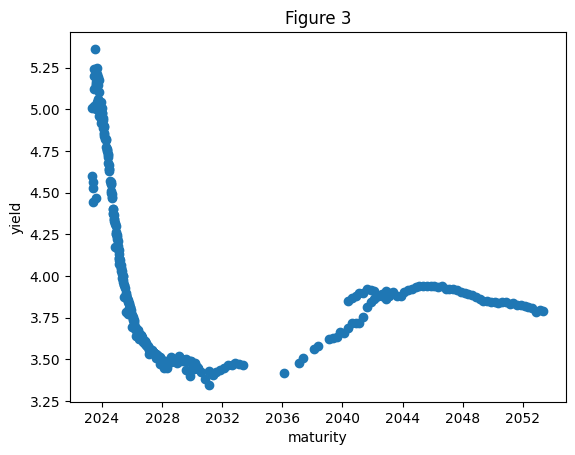

## b. True or False (fixed rate bond yields)

1. Fixed rate bond yield is increasing in interest rate
1. Fixed rate bond yield is increasing in credit spread
2. Fixed rate bond yield is increasing in coupon
3. Fixed rate bond yield is increasing in bond maturity
4. Fixed rate callable bond yields are lower or equal to their "bullet" (non-callable) version.

>1. True. Existing bond prices are inversely related to interest rates. Thus, when interest rates climb, the prices of current bonds diminish to align with the yield of newly issued equivalents.
>   
>2. True. The credit spread denotes an excess yield over the treasury yield. An augmented spread is indicative of greater risk and, hence, necessitates an increased yield, assuming other conditions remain constant.
>   
>3. False. The bond price adjusts in conjunction with the coupon to ensure the yield aligns with a comparable bond bearing a different coupon rate.
>   
>4. False. While the yield curve typically displays an upward slope under normal conditions, it only exhibits this characteristic for maturities between 2030 and 2045. The remainder of the curve follows a downward slope (refer to figure 3).
>   
>5. False. Callable bonds, due to their lower or equivalent price to non-callable bonds, inherently possess a higher yield. This increased yield compensates for the potential downside faced by the bondholder due to the callable feature.

## c. True or False (fixed rate bond durations)

1. Fixed rate bond duration is increasing with yield
2. Fixed rate bond duration is increasing in coupon
3. Fixed rate bond duration is increasing with bond maturity
4. Fixed rate callable bond durations are higher or equal to their "bullet" (non-callable) version .


>1. False. In low-yield scenarios, even minor yield changes can have a substantial impact. For instance, a decrease in yield from 2% to 1% will provoke a greater price fluctuation than a shift from 25% to 24%. This is a manifestation of the inverse relationship between bond prices and yields.
>
>2. False. Higher coupons result in a shorter duration because the distribution of cash flows is more front-loaded, implying a greater share is received prior to maturity.
>
>3. True. Duration, essentially a measure of the weighted average time to receive cash flows for fixed bonds, tends to extend with longer maturities, as cash flows are typically realized later.
>
>4. False. The presence of a call option implies that cash flows will be received either at the same time or sooner compared to non-callable bonds. Therefore, the duration for callable bonds will either match or be less than that of non-callable bonds.

## d. True or False (fixed rate bond convexities)

1. Fixed rate bond convexity is increasing with yield
2. Fixed rate bond convexity is increasing in coupon
3. Fixed rate bond convexity is increasing with bond maturity
4. Fixed rate callable bond convexities are higher or equal to their "bullet" (non-callable) version .


>1. False. Generally, bond convexity diminishes as yield escalates. Convexity gauges how the bond's duration responds to yield variations. With high yields, the alterations in duration due to further yield changes are mitigated, resulting in lower convexity.
>
>2. False. Convexity, which reflects the squared, weighted average time until cash flow receipt, decreases with higher coupon rates. Given all else is constant, a greater coupon rate boosts the weight of the coupon cash flows, subsequently reducing the bond's convexity.
>
>3. True. Holding other factors constant, a bond with a longer maturity will have higher convexity.
>
>4. False. The duration of a standard (bullet) bond and the short position on a call option move in opposing directions, resulting in the callable bond having a lower convexity compared to the non-callable bond.

# Problem 2: Credit Default Swaps (hazard rate model)
## a. True or False (CDS Premium Leg PV)

1. CDS premium leg PV is increasing in CDS Par Spread
2. CDS premium leg PV is increasing in interest rate
2. CDS premium leg PV is increasing in hazard rate
3. CDS premium leg PV is increasing in recovery rate
4. CDS premium leg PV is increasing in coupon
5. CDS premium leg PV is increasing in CDS maturity


>1. False.
>
>2. False. The PV of the CDS premium leg typically exhibits a declining relationship with the interest rate. The present value of forthcoming cash flows diminishes when interest rates escalate due to the intrinsic mechanics of cash flow discounting.
>
>3. False. The PV of the CDS premium leg recedes with a surge in the hazard rate. Elevated hazard rates infer a higher likelihood of default, thereby curtailing the anticipated cash flows from premium payments, as the protection seller may cease receiving premiums earlier due to a credit event.
>
>4. False. The PV of the CDS premium leg remains unaltered by the recovery rate. The calculation of the premium leg's present value is influenced by the survival probability of the reference entity and not the recovery rate.
>
>5. True. The PV of the CDS premium leg intensifies with the coupon rate. Elevated coupon rates lead to increased premium payments, thereby inflating the PV of the premium leg.
>
>6. True. The PV of the CDS premium leg swells with the CDS maturity. CDS contracts with longer maturity entail more premium payments, leading to an enlarged PV of the premium leg.

## b. True or False (CDS Default Leg PV)

1. CDS default leg PV is increasing in CDS Par Spread
2. CDS default leg PV is increasing in interest rate
3. CDS default leg PV is increasing in hazard rate
4. CDS default leg PV is increasing in recovery rate
5. CDS default leg PV is increasing in coupon
6. CDS default leg PV is increasing in CDS maturity

>1. True
>
>2. False. The PV of the CDS default leg ascends with the interest rate. Higher interest rates lead to larger discount rates, thereby deflating the present value of the default leg.
>
>3. True. The PV of the CDS default leg escalates with the hazard rate. An elevated hazard rate signals a higher default probability, thereby amplifying the expected cash flows from the protection leg.
>
>4. False. The PV of the CDS default leg contracts with an increase in the recovery rate. The recovery rate symbolizes the fraction of the bond's par value that can be retrieved post-default. A higher recovery rate implies a lesser loss given default, thereby reducing the payout on the default leg.
>
>5. False. The PV of the CDS default leg is uninfluenced by the coupon rate. The computation of the default leg's present value is based on the default probability of the reference entity and not the coupon rate.
>
>6. True. The PV of the CDS default leg typically rises with the CDS maturity. A more extended maturity widens the timeframe during which a default can transpire, thus augmenting the expected value of the default leg. Nevertheless, this is subject to the interplay of the hazard rate and the recovery rate.

## c. True or False (CDS PV)


1. CDS PV is increasing in CDS Par Spread
2. CDS PV is increasing in interest rate
3. CDS PV is increasing in hazard rate
4. CDS PV is increasing in recovery rate
5. CDS PV is increasing in coupon
6. CDS PV is increasing in CDS maturity

>1. False.
>
>2. False. Typically, the NPV of a CDS exhibits a declining trend with the interest rate. This is an upshot of the mechanism of discounting future cash flows. As interest rates climb, the present value of prospective cash flows diminishes.
>
>3. False. Generally, the NPV of a CDS is inversely proportional to the hazard rate. While an escalated hazard rate inflates the present value of the default leg, it shrinks the present value of the premium leg due to a possibly earlier cessation of premium receipts triggered by a credit event. The comprehensive effect on CDS NPV hinges on specific parameters, but it frequently leads to a decline in NPV.
>
>4. True. The NPV of a CDS exhibits an increasing trajectory with the recovery rate. An amplified recovery rate curtails the present value of the default leg, thereby elevating the overall CDS NPV, as the protection seller will likely have a smaller payout in a default event.
>
>5. True. The NPV of a CDS surges with the coupon rate. Amplified coupon rates trigger heftier premium payments, thereby augmenting the present value of the premium leg.
>
>6. True. The NPV of a CDS grows with the CDS maturity. CDS contracts with extended maturity have a greater number of premium payments, culminating in a larger present value of the premium leg. However, this outcome is dependent on the hazard rate and the recovery rate.

## d. True or False (CDS Par Spread)


1. CDS Par Spread is increasing in interest rates
2. CDS Par Spread is increasing in hazard rate
3. CDS Par Spread is increasing in recovery rate
4. CDS Par Spread is increasing in coupon
5. CDS Par Spread is increasing in CDS maturity

>1. False. Interest rate alterations do not directly correlate with the CDS par spread. The par spread is principally affected by credit risk elements, such as the default likelihood and recovery rate, rather than interest rate shifts.
>
>2. True. A hike in the hazard rate aligns with an escalation in the CDS par spread. The hazard rate signifies the default probability, and a greater hazard rate denotes a larger expected cash flow from the protection leg. Hence, the CDS par spread rises to offset the augmented risk.
>
>3. False. The CDS par spread exhibits an inverse relationship with the recovery rate. A boosted recovery rate suggests a reduced loss given default, implying that a greater fraction of the bond's par value can be retrieved post-default. Thus, the payout on the default leg diminishes, driving a lower CDS par spread.
>
>4. False. The CDS par spread does not directly respond to alterations in the coupon rate. The par spread is calibrated based on the reference entity's credit risk and signifies the coupon rate that equates the premium leg's present value with the protection leg's present value. Consequently, shifts in the coupon rate do not directly impact the CDS par spread.
>
>5. False. Usually, the CDS par spread tends to inflate with protracted CDS maturities. Extended maturities encompass more premium payments over time, leading to an augmented present value of the premium leg. However, specific circumstances such as a Federal Reserve commitment to extensive Quantitative Easing and support for a specified period may introduce additional risk in the long term.

# Problem 3: Perpetual CDS
We are interested in a perpetual CDS contract (infinite maturity) on a face notional of $100, flat interest rate of 4% and coupon of 5% (quarterly payments).

For simplicity, we assuming a flat hazard rate of 1% per annum, a rcovery of 40%, T+0 settlement and zero accrued.

## a. What is the fair value of the CDS premium leg?


> The fair value of the Credit Default Swap (CDS) premium leg can be computed by taking into account the present value of all future coupon payments.
>
> The premium leg of the CDS contract represents a stream of coupon payments made by the protection buyer to the protection seller. The coupon amount is calculated as the coupon rate times the notional amount of the contract. In this case, it's $1.25 quarterly (5% annually of $100 face notional, paid quarterly).
>
> Each of these future cash flows needs to be discounted back to the present to account for the time value of money and the probability of survival of the reference entity (no default). In this case, it's assumed that both the discount rate (interest rate) and the hazard rate (default rate) are constant over time.
>
> The present value of the premium leg (PV_premium) is then given by the sum of the discounted cash flows: PV_premium = Σ (Coupon amount) * (Discount factor) * (Survival probability)
>
> Considering the formula above, the survival probability at each quarter n is given by (1 - hazard rate) to the power n, and the discount factor is given by (1 + interest rate) to the power -n. The product of these two terms can be expressed as (1 - hazard rate) / (1 + interest rate) to the power n, or (0.9975 / 1.01) ** n in this case.
>
> As this is a perpetual contract (i.e., infinite maturity), the present value of the premium leg becomes the sum of an infinite geometric series. The sum of an infinite geometric series a / (1 - r) where 'a' is the first term of the series and 'r' is the common ratio. Here 'a' is the first coupon payment, $1.25, and 'r' is the ratio (0.9975 / 1.01).
>
>So, we have:
>\begin{align*}
>PV_{premium} = 1.25 / (1 - 0.9975/1.01)
>\end{align*}



In [67]:
pv_prem = 1.25/(1-0.9975/1.01)
pv_prem

100.99999999999991

## b. Compute the fair value of the CDS default leg and the CDS Par Spread.

>In a CDS contract, the default leg represents a potential single payment by the protection seller to the protection buyer, if a credit event occurs. In this case, it's assumed that the recovery rate is 40%, meaning that the loss given default is 60% of the face notional amount, or $60.
>
>Each potential default payment needs to be discounted back to the present, taking into account both the time value of money and the risk-neutral default probability. Here, we assume a constant hazard rate, which simplifies the calculation.
>
>The present value of the default leg (PV_default) is given by the sum of the discounted expected default payments:
>
>PV_default = Σ (Default payment) * (Discount factor) * (Default probability)
>
>For each quarter n, the default probability is the hazard rate $(0.0025)$ times the survival probability up to the previous quarter $(0.9975) ^ {(n - 1)}$, and the discount factor is $(1 + interest rate) ^ {-n}, or (1.01) ^ {-n}$. This gives us a present value for each potential default payment of 60 * 0.0025 / 0.9975 * (0.9975/1.01) ^ n.
>
>\begin{align*}
>PV_{default} = 60 * 0.0025 / 0.9975 / (1 - 0.9975/1.01)
>\end{align*}

In [68]:
pv_def = -(60 * 0.0025 / 0.9975 / (1 - 0.9975/1.01))
pv_def

-12.150375939849612

In [69]:
pl_01 = 1/(1-0.9975/1.01)* 0.25
parspread = pv_def / pl_01
parspread

-0.6015037593984962

## c. Compute the following CDS risk sensitivities:
- IR01
- HR01
- CS01 and
- REC01

using the scenario method.


In [70]:
class CDS:
    def __init__(self, cpn, hr, rec, ir):
        self.cpn = cpn
        self.hr = hr
        self.rec = rec
        self.ir = ir
    
    def pl_pv_calc(self):
        return 1 / (1 - (1 - self.hr / 4) / (1 + self.ir / 4)) * self.cpn / 4

    def dl_pv_calc(self):
        return 100 * (1 - self.rec) * (self.hr / 4) / (1 - self.hr / 4) * 1 / (1 - (1 - self.hr / 4) / (1 + self.ir / 4))

    def pv_cds_for_seller(self):
        return self.pl_pv_calc() - self.dl_pv_calc()

    def calculate_sensitivities(self):
        cds_pv = self.pv_cds_for_seller()

        # IR01
        cds_ir_down = CDS(self.cpn, self.hr, self.rec, self.ir - 0.0001)
        ir01 = (cds_ir_down.pv_cds_for_seller() - cds_pv) * 100

        # HR01
        cds_hr_down = CDS(self.cpn, self.hr - 0.0001, self.rec, self.ir)
        #price difference between two CDS divided by yield difference
        hr01 = (cds_hr_down.pv_cds_for_seller() - cds_pv) 

        # CS01
        cs01 = (hr01 / (1 - self.rec))

        # REC01
        cds_rec_up = CDS(self.cpn, self.hr, self.rec + 0.01, self.ir)
        rec01 = (cds_rec_up.pv_cds_for_seller() - cds_pv)

        return {"IR01": round(ir01,4), "HR01": round(hr01,4), "CS01": round(cs01,4), "REC01": round(rec01,4)}


cds = CDS(cpn = 5, hr = 0.01, rec = 0.4, ir = 0.04)
sensitivities = cds.calculate_sensitivities()
print(sensitivities)


{'IR01': 17.5852, 'HR01': 0.3001, 'CS01': 0.5002, 'REC01': 0.2025}


## d. At what time to maturity T does the (implied) default probability over next 5 years drop to 1%?

\begin{align}
\mathbb{P} \left(\tau \in [T, T+5] \right) = 1/100
\end{align}


>The code calculates the survival probability for each year and continues to increment the maturity until the five-year survival probability exceeds the 1% default probability. Once the survival probability condition is met, the function returns the maturity time in years.

In [71]:
def compute_maturity(hazard_rate=0.01, recovery_rate=0.4, coupon_rate=0.05, interest_rate=0.04, target_default_probability=0.01):
    time_to_maturity = 0
    survival_probability = 1.0

    while survival_probability ** 5 > 1 - target_default_probability:
        time_to_maturity += 1
        discount_factor = np.exp(-interest_rate * time_to_maturity)
        survival_probability *= np.exp(-hazard_rate * discount_factor)

    return time_to_maturity

maturity = compute_maturity()
print(f"Time to maturity (T) when default probability drops to 1%: {maturity} years")


Time to maturity (T) when default probability drops to 1%: 1 years


# Problem 4: CDS Intrinisc Index analysis on CDX IG 5Y


In [72]:
import QuantLib as ql
import numpy as np
import pandas as pd
import os
import datetime as dt

import matplotlib.pyplot as plt
%matplotlib inline
mydir = os.getcwd()

In [73]:
# Use static calculation/valuation date of 2023-05-12, matching data available in the market prices EOD file
calc_date = ql.Date(12, 5, 2023)
ql.Settings.instance().evaluationDate = calc_date

In [74]:
calc_date_str = '2023-05-12'

govt_symbology_df = pd.read_excel(os.path.join(mydir,'data', 'govt_symbology1.xlsx'))
govt_symbology_df.set_index('figi',inplace=True)

govt_otr_df = pd.read_excel(os.path.join(mydir,'data', 'govt_on_the_run1.xlsx'))
govt_otr_df = govt_otr_df[~govt_otr_df['ticker'].str.contains('B')]
govt_otr_df = govt_otr_df[~govt_otr_df['ticker'].str.contains('C')]
govt_otr_df.reset_index(drop=True, inplace=True)

on_the_run_tsy_figis = govt_otr_df['figi'].to_list()

# govt_otr_symbology_df
govt_otr_symbology_df = govt_symbology_df.loc[on_the_run_tsy_figis]

govt_market_prices_df = pd.read_excel(os.path.join(mydir,'data', 'govt_market_prices_eod1.xlsx'))
govt_market_prices_df.set_index('date',inplace=True)

treasury_otr_df = govt_otr_symbology_df.merge(govt_market_prices_df.loc[calc_date_str], how='left', on=['figi', 'class', 'ticker', 'isin'])
treasury_otr_df.sort_values('maturity',inplace=True)
print(treasury_otr_df[['figi', 'security', 'bid', 'ask', 'bid_yield', 'bid_yield']])

           figi          security       bid       ask  bid_yield  bid_yield
1  BBG01GCWF1J0  T 3 7/8 04/30/25   99.7773   99.7891      3.994      3.994
3  BBG01GJ2R1W1  T 3 5/8 05/15/26   99.9063   99.9141      3.658      3.658
5  BBG01GCWDXL9  T 3 1/2 04/30/28  100.2344  100.2422      3.448      3.448
6  BBG01GCWF002  T 3 1/2 04/30/30  100.2344  100.2969      3.462      3.462
0  BBG01GJ2R4D6  T 3 3/8 05/15/33   99.2031   99.2656      3.470      3.470
2  BBG01F6N6GN1  T 3 7/8 02/15/43   99.9063   99.9531      3.881      3.881
4  BBG01GJ2QXX1  T 3 5/8 05/15/53   97.0156   97.0781      3.792      3.792


In [75]:
treasury_otr_df = govt_otr_symbology_df.merge(govt_market_prices_df.loc[calc_date_str], how='left', on=['figi', 'class', 'ticker', 'isin'])
treasury_otr_df.sort_values('maturity',inplace=True)
print(treasury_otr_df[['figi', 'security', 'bid', 'ask', 'bid_yield', 'bid_yield']])

           figi          security       bid       ask  bid_yield  bid_yield
1  BBG01GCWF1J0  T 3 7/8 04/30/25   99.7773   99.7891      3.994      3.994
3  BBG01GJ2R1W1  T 3 5/8 05/15/26   99.9063   99.9141      3.658      3.658
5  BBG01GCWDXL9  T 3 1/2 04/30/28  100.2344  100.2422      3.448      3.448
6  BBG01GCWF002  T 3 1/2 04/30/30  100.2344  100.2969      3.462      3.462
0  BBG01GJ2R4D6  T 3 3/8 05/15/33   99.2031   99.2656      3.470      3.470
2  BBG01F6N6GN1  T 3 7/8 02/15/43   99.9063   99.9531      3.881      3.881
4  BBG01GJ2QXX1  T 3 5/8 05/15/53   97.0156   97.0781      3.792      3.792


In [76]:
def get_ql_date(date) -> ql.Date:
    """
    convert dt.date to ql.Date
    """
    if isinstance(date, dt.date):
        return ql.Date(date.day, date.month, date.year)
    elif isinstance(date, str):
        date = dt.datetime.strptime(date, "%Y-%m-%d").date()
        return ql.Date(date.day, date.month, date.year)
    else:
        raise ValueError(f"to_qldate, {type(date)}, {date}")


def create_schedule_from_symbology(details: dict):
    '''Create a QuantLib cashflow schedule from symbology details dictionary (usually one row of the symbology dataframe)
    '''
    # Create maturity from details['maturity']
    maturity = get_ql_date(details['maturity'])
    
    # Create acc_first from details['acc_first']
    acc_first = get_ql_date(details['acc_first'])
    
    # Create calendar for Corp and Govt asset classes
    calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
    
    # define period from details['cpn_freq'] ... can be hard-coded to 2 = semi-annual frequency
    period = ql.Period(2)
    
    # business_day_convention
    business_day_convention = ql.Unadjusted
    
    # termination_date_convention
    termination_date_convention = ql.Unadjusted
    
    # date_generation
    date_generation=ql.DateGeneration.Backward
    
    # Create schedule using ql.MakeSchedule interface (with keyword arguments)
    schedule = ql.MakeSchedule(effectiveDate=acc_first,  # this may not be the same as the bond's start date
                            terminationDate=maturity,
                            tenor=period,
                            calendar=calendar,
                            convention=business_day_convention,
                            terminalDateConvention=termination_date_convention,
                            rule=date_generation,
                            endOfMonth=True,
                            firstDate=ql.Date(),
                            nextToLastDate=ql.Date())
    return schedule

def create_bond_from_symbology(details: dict):
    '''Create a US fixed rate bond object from symbology details dictionary (usually one row of the symbology dataframe)
    '''
    
     # Create day_count from details['dcc']
     # For US Treasuries use ql.ActualActual(ql.ActualActual.ISMA)
     # For US Corporates use ql.Thirty360(ql.Thirty360.USA)
    if details['dcc'] == '30/360':
        day_count = ql.Thirty360(ql.Thirty360.USA)
    elif details['dcc'] == 'ACT/ACT':
        day_count = ql.ActualActual(ql.ActualActual.ISMA)
    else:
        raise ValueError(f"unsupported day count, {type(details['dcc'])}, {details['dcc']}")
    
    # Create day_count from details['start_date']    
    issue_date = get_ql_date(details['start_date'])
    
    # Create days_settle from details['days_settle']
    days_settle = int(float(details['days_settle']))

    # Create days_settle from details['coupon']
    coupon = float(details['coupon'])/100.

    # Create cashflow schedule
    schedule = create_schedule_from_symbology(details)
    
    face_value = 100
    redemption = 100
    
    payment_convention = ql.Unadjusted
        
    # Create fixed rate bond object
    fixed_rate_bond = ql.FixedRateBond(
        days_settle,
        face_value,
        schedule,
        [coupon],
        day_count,
        payment_convention,
        redemption,
        issue_date)        

    return fixed_rate_bond

def calibrate_yield_curve_from_frame(
        calc_date: ql.Date,
        treasury_details: pd.DataFrame,
        price_quote_column: str):
    '''Create a calibrated yield curve from a details dataframe which includes bid/ask/mid price quotes.
    '''
    ql.Settings.instance().evaluationDate = calc_date

    # Sort dataframe by maturity
    sorted_details_frame = treasury_details.sort_values(by='maturity')    
    
    # For US Treasuries use ql.ActualActual(ql.ActualActual.ISMA)
    day_count = ql.ActualActual(ql.ActualActual.ISMA)

    bond_helpers = []
    
    for index, row in sorted_details_frame.iterrows():
        bond_object = create_bond_from_symbology(row)
        
        tsy_clean_price_quote = row[price_quote_column]
        tsy_clean_price_handle = ql.QuoteHandle(ql.SimpleQuote(tsy_clean_price_quote))
        
        bond_helper = ql.BondHelper(tsy_clean_price_handle, bond_object)
        bond_helpers.append(bond_helper)
        
    yield_curve = ql.PiecewiseLogCubicDiscount(calc_date, bond_helpers, day_count)
    yield_curve.enableExtrapolation()
    return yield_curve

In [77]:
# tsy_yield_curve calibration
tsy_yield_curve = calibrate_yield_curve_from_frame(calc_date, treasury_otr_df, 'mid_clean')
tsy_yield_curve_handle = ql.YieldTermStructureHandle(tsy_yield_curve)

## a. Load and explore the CDX IG 5Y symbology, basket composition and market data

Load the `cdx_symbology` Excel file into a dataframe. Identify the CDX IG 5Y Series 40 index.

Load the `cdx_basket_composition` Excel file into a dataframe. It contains the CDX IG 5Y Series 40 basket composition and CDS Par Spread quotes as of 2023-05-12.

How many CDS contracts are in the CDX index basket? What are the contractual specs and weights of each CDS? Remember that each CDS is identical to the CDX index and the basket has uniform weights.

Compute mean, median and standard deviation of CDS Par Spreads in the basket.

Sort the basket dataframe by CDS Par Spreads and plot the chart of CDS Par Spreads.

In [78]:
cdx_symbology = pd.read_excel(os.path.join(mydir,'data', 'cdx_symbology.xlsx'))
cdx_symbology.head()

,symbol,ticker,class,security,name,type,dcc,cpn_first,maturity,currency
0,CDX_CDXIG039,CDXIG039,Curncy,MARKIT CDX IG,MARKIT CDX.NA.IG.39 12/32,CREDIT DEFAULT SWAP,ACT/360,2022-12-20,2032-12-20,USD
1,CDX_CDXIG040,CDXIG040,Curncy,MARKIT CDX IG,MARKIT CDX.NA.IG.40 06/33,CREDIT DEFAULT SWAP,ACT/360,2023-06-20,2033-06-20,USD
2,CDX_CDXIG139,CDXIG139,Curncy,MARKIT CDX IG,MARKIT CDX.NA.IG.39 12/23,CREDIT DEFAULT SWAP,ACT/360,2022-12-20,2023-12-20,USD
3,CDX_CDXIG140,CDXIG140,Curncy,MARKIT CDX IG,MARKIT CDX.NA.IG.40 06/24,CREDIT DEFAULT SWAP,ACT/360,2023-06-20,2024-06-20,USD
4,CDX_CDXIG239,CDXIG239,Curncy,MARKIT CDX IG,MARKIT CDX.NA.IG.39 12/24,CREDIT DEFAULT SWAP,ACT/360,2022-12-20,2024-12-20,USD


In [79]:
cdx_symbology[cdx_symbology['ticker'] == 'CDXIG540']

,symbol,ticker,class,security,name,type,dcc,cpn_first,maturity,currency
9,CDX_CDXIG540,CDXIG540,Curncy,MARKIT CDX IG,MARKIT CDX.NA.IG.40 06/28,CREDIT DEFAULT SWAP,ACT/360,2023-06-20,2028-06-20,USD


In [80]:
cdx_basket = pd.read_excel(os.path.join(mydir,'data', 'cdx_ig_40_5y_basket_composition.xlsx'))
cdx_basket

,date,index_symbol,index_weight,ticker,name,seniority,sector,currency,doc_clause,cds_par_spread_5y,cds_recovery
0,2023-05-12,CDX_CDXIG540,0.8,ABX,Barrick Gold Corp,SNRFOR,Basic Materials,USD,XR14,60.35,0.4
1,2023-05-12,CDX_CDXIG540,0.8,AEP,Amern Elec Pwr Co Inc,SNRFOR,Utilities,USD,XR14,50.29,0.4
2,2023-05-12,CDX_CDXIG540,0.8,AES,The AES Corp,SNRFOR,Utilities,USD,XR14,146.67,0.4
3,2023-05-12,CDX_CDXIG540,0.8,AIG,Amern Intl Gp Inc,SNRFOR,Financials,USD,XR14,105.26,0.4
4,2023-05-12,CDX_CDXIG540,0.8,ALL,Allstate Corp,SNRFOR,Financials,USD,XR14,37.82,0.4
...,...,...,...,...,...,...,...,...,...,...,...
120,2023-05-12,CDX_CDXIG540,0.8,VRZN,Verizon Comms Inc,SNRFOR,Telecommunications Services,USD,XR14,106.36,0.4
121,2023-05-12,CDX_CDXIG540,0.8,WALMINC,WALMART INC,SNRFOR,Consumer Services,USD,XR14,34.64,0.4
122,2023-05-12,CDX_CDXIG540,0.8,WHR,Whirlpool Corp,SNRFOR,Consumer Goods,USD,XR14,155.92,0.4
123,2023-05-12,CDX_CDXIG540,0.8,WMB,WILLIAMS COS INC,SNRFOR,Energy,USD,XR14,105.15,0.4


In [81]:
#How many CDS Contracts are in the CDXIG540 basket?
cdx_basket.shape[0]

125

In [82]:
print(f'The index weight of each CDS contract in the CDXIG540 basket is {1/cdx_basket.shape[0]:.2%}')

The index weight of each CDS contract in the CDXIG540 basket is 0.80%


In [83]:
#Mean median and std dev of the cds par spreads
cdx_basket.describe().iloc[:,1]

count    125.000000
mean      87.348720
std       55.735455
min       20.160000
25%       48.640000
50%       67.880000
75%      109.850000
max      337.710000
Name: cds_par_spread_5y, dtype: float64

<Axes: title={'center': 'CDXIG540 CDS Par Spreads'}>

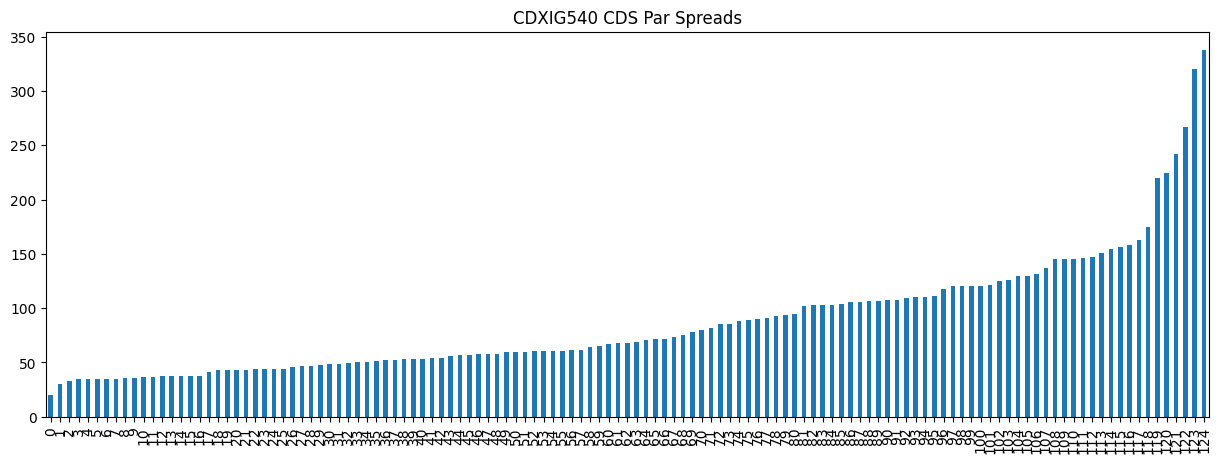

In [84]:
#sort the baset dataframe by cds par spread and plot the sorted par spreads
cdx_basket.sort_values(by='cds_par_spread_5y', inplace=True)
cdx_basket.reset_index(drop=True, inplace=True)
cdx_basket['cds_par_spread_5y'].plot(kind='bar', figsize=(15, 5), title='CDXIG540 CDS Par Spreads')

## b. Calibrate the US SOFR yield curve (via bootstrapping)
Load the `sofr_swap_symbology` Excel file into a dataframe.

Load the `sofr_swaps_market_data_eod` Excel file into a dataframe. Print all dates available.

Follow Homework 3, Problem 3 and calibrate the SOFR discount curve as of 2023-05-12. You can use the SOFR calibration function below.

In [85]:
sofr_symbology_df = pd.read_excel(os.path.join(mydir,'data', 'sofr_swaps_symbology1.xlsx'))
sofr_symbology_df.set_index('figi',inplace=True)

In [86]:
sofr_market_quotes_df = pd.read_excel(os.path.join(mydir,'data', 'sofr_swaps_market_data_eod1.xlsx'))
sofr_market_quotes_df.set_index('date',inplace=True)
sofr_market_quotes_df.columns = ['figi', 'mid_rate']
sofr_market_quotes_df

,figi,mid_rate
date,,
2023-01-03,BBG00KFWPJJ9,4.8878
2023-01-03,BBG00KFWPJX3,4.3938
2023-01-03,BBG00KFWPK15,3.9778
2023-01-03,BBG00KFWPK51,3.6224
2023-01-03,BBG00KFWPK79,3.4814
...,...,...
2023-05-12,BBG00KFWPK51,3.2426
2023-05-12,BBG00KFWPK79,3.1750
2023-05-12,BBG00KFWPKB4,3.1800


In [87]:
def calibrate_sofr_curve_from_frame(
        calc_date: ql.Date,
        sofr_details: pd.DataFrame,
        rate_quote_column: str):
    '''Create a calibrated yield curve from a SOFR details dataframe which includes rate quotes.
    '''
    ql.Settings.instance().evaluationDate = calc_date

    # Sort dataframe by maturity
    sorted_details_frame = sofr_details.sort_values(by='term')    
    
    # settle_days
    settle_days = 2
    
    # For US SOFR OIS Swaps 
    day_count = ql.Actual360()

    # For US SOFR Swaps     
    calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
    
    sofr_helpers = []
    
    for index, row in sorted_details_frame.iterrows():
        sofr_quote = row[rate_quote_column]
        tenor_in_years = row['term']
        sofr_tenor = ql.Period(tenor_in_years, ql.Years)
        
        # create sofr_rate_helper
        sofr_helper = ql.OISRateHelper(settle_days, sofr_tenor, ql.QuoteHandle(ql.SimpleQuote(sofr_quote/100)), ql.Sofr())
                        
        sofr_helpers.append(sofr_helper)
        
    sofr_yield_curve = ql.PiecewiseLinearZero(settle_days, calendar, sofr_helpers, day_count)
    sofr_yield_curve.enableExtrapolation()
    
    return sofr_yield_curve

In [88]:
calc_date_str = '2023-05-12'

In [89]:
sofr_df = sofr_symbology_df.merge(sofr_market_quotes_df.loc[calc_date_str], how='left', on=['figi'])
print(sofr_df[['figi', 'name', 'mid_rate']])

           figi                      name  mid_rate
0  BBG00KFWPJJ9   USD OIS  ANN VS SOFR 1Y    4.6945
1  BBG00KFWPJX3   USD OIS  ANN VS SOFR 2Y    3.9097
2  BBG00KFWPK15   USD OIS  ANN VS SOFR 3Y    3.5265
3  BBG00KFWPK51   USD OIS  ANN VS SOFR 5Y    3.2426
4  BBG00KFWPK79   USD OIS  ANN VS SOFR 7Y    3.1750
5  BBG00KFWPKB4  USD OIS  ANN VS SOFR 10Y    3.1800
6  BBG00KFWPKF0  USD OIS  ANN VS SOFR 20Y    3.2160
7  BBG00KFWPKH8  USD OIS  ANN VS SOFR 30Y    3.0673


In [90]:
# sofr_yield_curve calibration
sofr_yield_curve = calibrate_sofr_curve_from_frame(calc_date, sofr_df, 'mid_rate')
sofr_yield_curve_handle = ql.YieldTermStructureHandle(sofr_yield_curve)

In [91]:
def get_yield_curve_details_df(yield_curve, curve_dates=None):
    
    if(curve_dates == None):
        curve_dates = yield_curve.dates()

    dates = [d.to_date() for d in curve_dates]
    discounts = [round(yield_curve.discount(d), 3) for d in curve_dates]
    yearfracs = [round(yield_curve.timeFromReference(d), 3) for d in curve_dates]
    zeroRates = [round(yield_curve.zeroRate(d, yield_curve.dayCounter(), ql.Compounded).rate() * 100, 3) for d in curve_dates]

    yield_curve_details_df = pd.DataFrame(data={'Date': dates,
                             'YearFrac': yearfracs,
                             'DiscountFactor': discounts,
                             'ZeroRate': zeroRates})                             
    return yield_curve_details_df

In [92]:
# Display and plot SOFR yield curve
grid_dates = [sofr_yield_curve.referenceDate() + ql.Period(y, ql.Years) for y in list(range(0,30,2))]


sofr_yield_curve_simple_df = get_yield_curve_details_df(sofr_yield_curve)                  # using calibration grid
sofr_yield_curve_details_df = get_yield_curve_details_df(sofr_yield_curve, grid_dates)    # using external grid

print(sofr_yield_curve_simple_df)
print(sofr_yield_curve_details_df)

         Date  YearFrac  DiscountFactor  ZeroRate
0  2023-05-16     0.000           1.000     4.693
1  2024-05-16     1.017           0.954     4.693
2  2025-05-16     2.031           0.925     3.893
3  2026-05-18     3.050           0.900     3.502
4  2028-05-16     5.075           0.852     3.214
5  2030-05-16     7.103           0.802     3.149
6  2033-05-16    10.147           0.729     3.162
7  2043-05-18    20.297           0.526     3.215
8  2053-05-16    30.439           0.406     3.004
          Date  YearFrac  DiscountFactor  ZeroRate
0   2023-05-16     0.000           1.000     4.693
1   2025-05-16     2.031           0.925     3.893
2   2027-05-16     4.058           0.875     3.359
3   2029-05-16     6.089           0.826     3.182
4   2031-05-16     8.117           0.777     3.153
5   2033-05-16    10.147           0.729     3.162
6   2035-05-16    12.175           0.684     3.173
7   2037-05-16    14.206           0.641     3.183
8   2039-05-16    16.233           0.600 

Text(0.5, 0, 'Date')

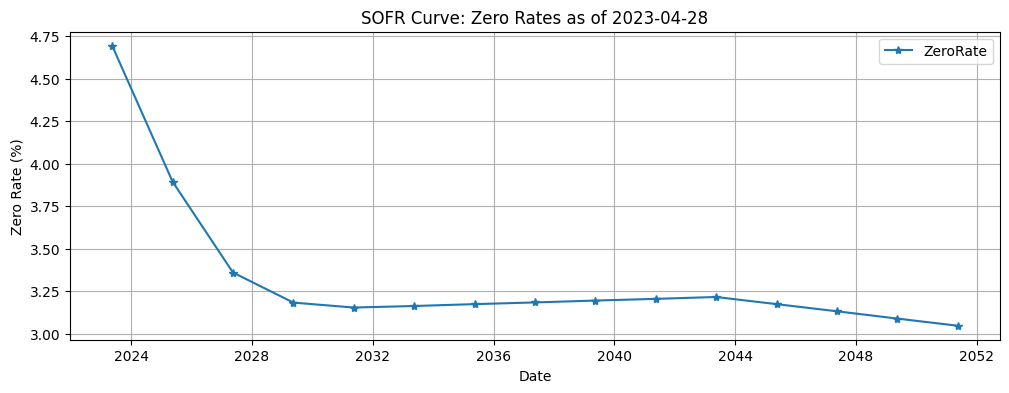

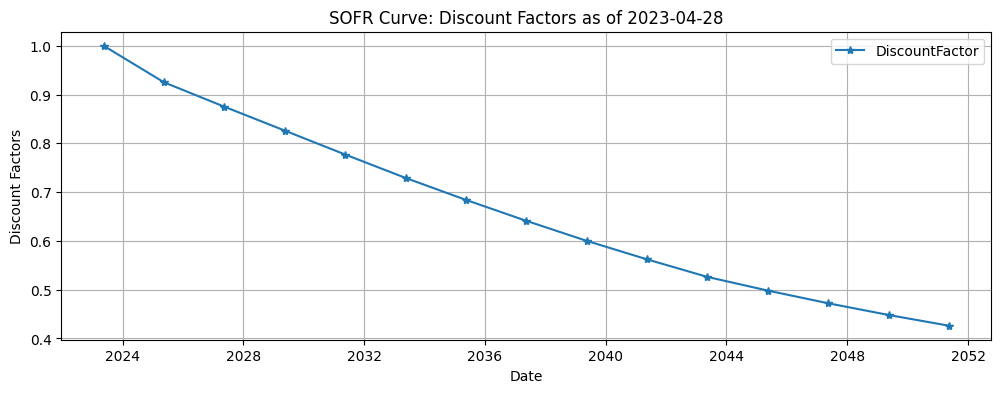

In [93]:
# Plot the SOFR yield curve
plt = sofr_yield_curve_details_df.plot(x='Date', y='ZeroRate', grid=True, style='*-', title='SOFR Curve: Zero Rates as of 2023-04-28', figsize=(12,4))
plt.set_ylabel('Zero Rate (%)')
plt.set_xlabel('Date')

plt = sofr_yield_curve_details_df.plot(x='Date', y='DiscountFactor', grid=True, style='*-', title='SOFR Curve: Discount Factors as of 2023-04-28', figsize=(12,4))
plt.set_ylabel('Discount Factors')
plt.set_xlabel('Date')

## c. Compute the intrinsic Premium Leg PV of the CDX index basket

For each instrument in the basket, create the CDS object and calibrate the corresponding hazard rate / survival probability curve.

Compute the Premium Leg PV for each CDS and determine the intrinsic Premium Leg PV of the basket (using basket weights).

In [94]:
def calibrate_cds_hazard_rate_curve(calc_date, sofr_yield_curve_handle, cds_par_spreads_bps, cds_recovery_rate = 0.4):
    '''Calibrate hazard rate curve from CDS Par Spreads'''
    CDS_settle_days = 2

    CDS_day_count = ql.Actual360()

    # CDS standard tenors: 1Y, 2Y, 3Y, 5Y 7Y and 10Y
    CDS_tenors = [ql.Period(y, ql.Years) for y in [1, 2, 3, 5, 7, 10]]
              

    CDS_helpers = [ql.SpreadCdsHelper((cds_par_spread / 10000.0), CDS_tenor, CDS_settle_days, ql.TARGET(),
                                  ql.Quarterly, ql.Following, ql.DateGeneration.TwentiethIMM, CDS_day_count, cds_recovery_rate, sofr_yield_curve_handle)
               
    for (cds_par_spread, CDS_tenor) in zip(cds_par_spreads_bps, CDS_tenors)]

    # bootstrap hazard_rate_curve
    hazard_rate_curve = ql.PiecewiseFlatHazardRate(calc_date, CDS_helpers, CDS_day_count)
    hazard_rate_curve.enableExtrapolation()

    return(hazard_rate_curve)

In [95]:
# hazard_rate_curve calibration
cds_par_spreads = cdx_basket['cds_par_spread_5y'].tolist()
cds_recovery_rate = 0.4

# hazard_rate_curve
hazard_rate_curve = calibrate_cds_hazard_rate_curve(calc_date, sofr_yield_curve_handle, cds_par_spreads, cds_recovery_rate)
default_prob_curve_handle = ql.DefaultProbabilityTermStructureHandle(hazard_rate_curve)

#### Create CDS Bond objects

In [96]:
cdx_symbology.head(2)

,symbol,ticker,class,security,name,type,dcc,cpn_first,maturity,currency
0,CDX_CDXIG039,CDXIG039,Curncy,MARKIT CDX IG,MARKIT CDX.NA.IG.39 12/32,CREDIT DEFAULT SWAP,ACT/360,2022-12-20,2032-12-20,USD
1,CDX_CDXIG040,CDXIG040,Curncy,MARKIT CDX IG,MARKIT CDX.NA.IG.40 06/33,CREDIT DEFAULT SWAP,ACT/360,2023-06-20,2033-06-20,USD


In [97]:
#Make a dictionary with column names as keys and row values corresponding to ticker=='CDXIG540' from the cdx_symbology dataframe
cdx_540 = cdx_symbology[cdx_symbology['ticker']=='CDXIG540'].to_dict('records')[0]
cdx_540

{'symbol': 'CDX_CDXIG540',
 'ticker': 'CDXIG540',
 'class': 'Curncy',
 'security': 'MARKIT CDX IG',
 'name': 'MARKIT CDX.NA.IG.40 06/28',
 'type': 'CREDIT DEFAULT SWAP',
 'dcc': 'ACT/360',
 'cpn_first': Timestamp('2023-06-20 00:00:00'),
 'maturity': Timestamp('2028-06-20 00:00:00'),
 'currency': 'USD'}

In [98]:
cds_start_date = ql.Date(12,5,2023)
#get the maturity date from the cdx_540 dictionary 'maturity' and convert it to a ql.Date object
cdx_mat_date = ql.Date(cdx_540['maturity'].day, cdx_540['maturity'].month, cdx_540['maturity'].year)
def create_cds_objects(details:dict, cds_start_date:ql.Date, cds_maturity_date:ql.Date, default_prob_curve_handle:ql.DefaultProbabilityTermStructureHandle, sofr_yield_curve_handle:ql.YieldTermStructureHandle):
    # CDS specs
    side = ql.Protection.Seller
    
    CDS_recovery_rate = 0.4

    face_notional = 100

    contractual_spread = details['cds_par_spread_5y'] / 10000.0
    
    # Create CDS schedule
    cds_schedule = ql.MakeSchedule(cds_start_date, cds_maturity_date, ql.Period('3M'),
                            ql.Quarterly, ql.TARGET(), ql.Following, ql.Unadjusted, ql.DateGeneration.TwentiethIMM)
    
    # Create CDS object
    cds_obj = ql.CreditDefaultSwap(side, face_notional, contractual_spread, cds_schedule, ql.Following, ql.Actual360())
    
    cds_engine = ql.MidPointCdsEngine(default_prob_curve_handle, CDS_recovery_rate, sofr_yield_curve_handle)
    cds_obj.setPricingEngine(cds_engine)
    
    return cds_obj

In [99]:
# Compute CDS-Implied intrinsic prices for each CDS in the basket
flat_recovery_rate = 0.40

# Premium leg PV
premium_pv = []
default_pv = []

# Go through each CDS in the basket
for index, row in cdx_basket.iterrows():
    cds_obj = create_cds_objects(row, cds_start_date, cdx_mat_date, default_prob_curve_handle, sofr_yield_curve_handle)
    premium_pv.append(cds_obj.couponLegNPV())
    default_pv.append(cds_obj.defaultLegNPV())
    
cdx_basket['premium_pv'] = premium_pv
cdx_basket['default_pv'] = default_pv
    

In [100]:
cdx_basket[['ticker', 'cds_par_spread_5y', 'premium_pv']]

,ticker,cds_par_spread_5y,premium_pv
0,BRK,20.16,0.939345
1,JNJ,30.48,1.420199
2,MCD,32.40,1.509661
3,HD,34.23,1.594929
4,CSX,34.45,1.605180
...,...,...,...
120,RDN,224.43,10.457197
121,DXCTEC,241.80,11.266543
122,PARAMGL,267.10,12.445383
123,LNC,319.78,14.899980


In [101]:
# Compute the intrinsic Premium Leg PV of the basket using the basekt weights
cdx_basket['premium_pv_weighted'] = cdx_basket['premium_pv'] * cdx_basket['index_weight'] /100

print('Premium Leg PV of the basket (mean): ', cdx_basket['premium_pv_weighted'].sum())

Premium Leg PV of the basket (mean):  4.069967385693602


## d. Compute the intrinsic Default Leg PV of the CDX index basket

Compute the Default Leg PV for each CDS and determine the intrinsic Default Leg PV of the basket (using basket weights).

In [102]:
cdx_basket[['ticker', 'cds_par_spread_5y', 'premium_pv','default_pv']]

,ticker,cds_par_spread_5y,premium_pv,default_pv
0,BRK,20.16,0.939345,-1.593201
1,JNJ,30.48,1.420199,-1.593201
2,MCD,32.40,1.509661,-1.593201
3,HD,34.23,1.594929,-1.593201
4,CSX,34.45,1.605180,-1.593201
...,...,...,...,...
120,RDN,224.43,10.457197,-1.593201
121,DXCTEC,241.80,11.266543,-1.593201
122,PARAMGL,267.10,12.445383,-1.593201
123,LNC,319.78,14.899980,-1.593201


In [103]:
# Compute the intrinsic Premium Leg PV of the basket using the basekt weights
cdx_basket['default_pv_weighted'] = cdx_basket['default_pv'] * cdx_basket['index_weight'] /100

print('Deafult Leg PV of the basket weighted (mean): ', cdx_basket['default_pv_weighted'].sum())

Deafult Leg PV of the basket weighted (mean):  -1.5932006260909328


## e. Compute the intrinsic PV and Par Spread of the CDX index basket

Compute the intrinsic index PV. 

Compute the CDX instrinsic index Par Spread (using ratio of CDX default vs premium legs).

In [104]:
# Compute the intrinsic index PV
print('Index PV (mean): ', cdx_basket['premium_pv_weighted'].sum() + cdx_basket['default_pv_weighted'].sum())

# Compute the intrinsic index Par spread using ratio of CDX default leg PV to premium leg PV
print('Index Par Spread (bps): ', cdx_basket['default_pv_weighted'].sum() / cdx_basket['premium_pv_weighted'].sum() * 10000)

Index PV (mean):  2.476766759602669
Index Par Spread (bps):  -3914.529221268982


# Problem 5: Credit ETF analysis on HYG

## a. Load and explore the HYG basket composition and market data

Load the `hyg_basket_composition` Excel file into a dataframe. It contains the HYG basket constituent face notionals, weights and yields-to-maturities as of 2023-05-12.

Load the `hyg_corp_symbology` Excel file into a dataframe. It contains the corporate bond details for HYG constituents.

How many corporate bonds are in the HYG basket?  What are the average and median face notionals for a bond?

How many unique tickers are in the HYG basket? What are the average and median face notionals for a ticker?

Compute mean, median and standard deviation of yields-to-maturity of bonds in the basket.

In [105]:
hyg_basket_composition = pd.read_excel(mydir + '/data/hyg_basket_composition.xlsx')

In [106]:
hyg_corp_symbology = pd.read_excel(mydir + '/data/hyg_corp_symbology.xlsx')

In [107]:
print(f'Number of corp bonds in the HYG basket are {len(hyg_basket_composition)}')
print(f'The averge face notional of the bonds in the HYG basket is ${round(hyg_basket_composition["face_notional"].mean(),2)}')
print(f'The median face notional of the bonds in the HYG basket is ${round(hyg_basket_composition["face_notional"].median(),2)}')

Number of corp bonds in the HYG basket are 1200
The averge face notional of the bonds in the HYG basket is $13665815.83
The median face notional of the bonds in the HYG basket is $11397000.0


In [108]:
hyg_df = hyg_basket_composition.merge(hyg_corp_symbology, on='isin', suffixes=('', '_sym'))

In [109]:
print(f'The number of tickers in the HYG basket is {len(hyg_df.ticker.unique())}')
print(f'The average face notional per ticker (sum) in the HYG basket is ${round(hyg_df.groupby("ticker")["face_notional"].sum().mean(),2)}')
print(f'The median face notional per ticker (sum) in the HYG basket is ${round(hyg_df.groupby("ticker")["face_notional"].sum().median(),2)}')

The number of tickers in the HYG basket is 417
The average face notional per ticker (sum) in the HYG basket is $39326088.73
The median face notional per ticker (sum) in the HYG basket is $27703000.0


In [110]:
#Compute mean, median and standard deviation of yields-to-maturity of bonds in the basket.
print(f'The average yield-to-maturity of bonds in the HYG basket is {round(hyg_df["yield_to_maturity"].mean(),2)}%')
print(f'The median yield-to-maturity of bonds in the HYG basket is {round(hyg_df["yield_to_maturity"].median(),2)}%')
print(f'The standard deviation of yield-to-maturity of bonds in the HYG basket is {round(hyg_df["yield_to_maturity"].std(),2)}%')

The average yield-to-maturity of bonds in the HYG basket is 8.76%
The median yield-to-maturity of bonds in the HYG basket is 7.29%
The standard deviation of yield-to-maturity of bonds in the HYG basket is 5.03%


## b. Compute the NAV of the HYG basket and the intrinsic price of one ETF share.

Create the bond objects for all constituents of HYG. Compute the dirty price for each bond (from yield-to-maturity).

Aggregate the ETF NAV value (intrisic value of bond basket) as the weighted sum of dirty prices times basket weights. Keep in mind that the resulting ETF NAV will be on a face of $100, since the basket face notional weights add up to 100 percent.

Compute the intrinisc market capitalization of the HYG ETF by scaling the ETF NAV price to the ETF total face notional. 

Divide by 195,800,000 (the number of ETF shared outstanding as of 2023-05-12) to obtain the intrinsic price of one HYG ETF share.

In [111]:
shares_outstanding = 195_800_000
    

In [112]:
def calculate_dirty_price(hyg_df, calc_date=ql.Date.todaysDate()):
    for i in hyg_df.index:
        row = hyg_df.loc[i]

        bond = create_bond_from_symbology(row)
        hyg_df.loc[i,'bond_obj'] = bond

        flat_rate = ql.SimpleQuote(row['yield_to_maturity'] / 100)
        rate_handle = ql.QuoteHandle(flat_rate)

        day_count = ql.Actual360()
        calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
        continuous_comp = ql.Continuous 

        flat_yield_curve = ql.FlatForward(calc_date, rate_handle, day_count, continuous_comp)
        flat_yield_curve_handle = ql.YieldTermStructureHandle(flat_yield_curve)

        bond_engine = ql.DiscountingBondEngine(flat_yield_curve_handle)
        bond.setPricingEngine(bond_engine)

        hyg_df.loc[i, 'dirty_price'] = bond.dirtyPrice()
    return hyg_df


In [113]:
hyg_df = calculate_dirty_price(hyg_df, calc_date)

In [114]:
hyg_df[['ticker', 'yield_to_maturity', 'face_notional','dirty_price']]

,ticker,yield_to_maturity,face_notional,dirty_price
0,TDG,6.37,67227000,100.232026
1,MEDIND,6.60,70852000,86.467660
2,TIBX,9.00,64161000,88.160926
3,DISH,13.37,56232000,92.550773
4,AAL,6.22,56469000,97.982263
...,...,...,...,...
1195,WFRD,8.87,201000,107.510949
1196,SIX,6.41,103000,103.358291
1197,LUMN,22.69,200000,43.482350
1198,DBD,50.00,381000,30.422764


In [115]:
total_asset = (hyg_df['dirty_price'] * hyg_df['face_notional']).sum() / 100
nav_today = total_asset / shares_outstanding


print(f'The total asset value of the HYG ETF is ${round(total_asset,2)}')
print(f'The NAV of the HYG ETF is ${round(nav_today,2)}')
print(f'The closing price as per the Bloomberg terminal is $74.42 as on 05/12')

The total asset value of the HYG ETF is $14550779498.84
The NAV of the HYG ETF is $74.31
The closing price as per the Bloomberg terminal is $74.42 as on 05/12


## c. Compute the ETF yield using the ACF (Aggregated Cash-Flows) method

Create the bond objects for all constituents of HYG. 

Write a function that computes the ETF NAV for a given flat yield y.

Solve for 

ETF_NAV(yield) = ETF_NAV_Price 

to obtain the ETF yield.


In [116]:
def calculate_etf_nav(flat_yield):
    day_count = ql.Actual360()
    calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
    continuous_comp = ql.Continuous

    rate_handle = ql.QuoteHandle(ql.SimpleQuote(flat_yield))
    flat_yield_curve = ql.FlatForward(calc_date, rate_handle, day_count, continuous_comp)
    flat_yield_curve_handle = ql.YieldTermStructureHandle(flat_yield_curve)
    bond_engine = ql.DiscountingBondEngine(flat_yield_curve_handle)

    hyg_df['bond_obj'].apply(lambda bond: bond.setPricingEngine(bond_engine))
    hyg_df['dirty_price_flat_yield'] = hyg_df['bond_obj'].apply(lambda bond: bond.dirtyPrice())

    total_assets = (hyg_df['dirty_price_flat_yield'] * hyg_df['face_notional']).sum() / 100
    return total_assets / shares_outstanding


In [123]:
def re_func(flat_yield, nav):
    return calculate_etf_nav(flat_yield) - nav

In [124]:
#minimizeing the function re_func to find the flat yield that will make the NAV of the ETF equal to the market price
from scipy import optimize

flat_yield = optimize.newton(re_func, 0.05, args=(nav_today,))

print(f'The flat yield that will make the NAV of the ETF equal to the market price is {round(flat_yield*100,3)}%')

The flat yield that will make the NAV of the ETF equal to the market price is 8.391%


In [125]:
#import basin-hopping algorithm
from scipy.optimize import basinhopping

#run basin hopping to minimize the function re_func
minimizer_kwargs = {"args": (nav_today,)}
ret = basinhopping(re_func, 0.05, minimizer_kwargs=minimizer_kwargs, niter=1000)

print(f'The flat yield that will make the NAV of the ETF equal to the market price is {round(ret.x[0]*100,3)}%')

TypeError: in method 'new_SimpleQuote', argument 1 of type 'Real'

## d. Compute the ETF DV01, Duration and Convexity

Treat the ETF basket as a synthetic bond.

Use +/- 1 bp scenarios in ETF yield space to compute the ETF DV01, Duration and Convexity.


In [119]:
#Lets calculate the scenario bumps to get the DV01 of the ETF
nav_func = calculate_etf_nav(flat_yield)

nav_up_1bp = calculate_etf_nav(flat_yield + 0.0001)
nav_down_1bp = calculate_etf_nav(flat_yield - 0.0001)

In [120]:
dv01 = (nav_down_1bp - nav_func) * 100
print(f'The DV01 of the ETF is {round(dv01,3)}')
duration = dv01 / nav_func* 100
print(f'The duration of the ETF is {round(duration,3)}')
gamma = (nav_down_1bp + nav_up_1bp - 2 * nav_func) * 1000000
print(f'The gamma of the ETF is {round(gamma,2)}')
convexity = round(gamma / nav_func * 100, 4)

print(f'The convexity of the ETF is {convexity}')


The DV01 of the ETF is 3.227
The duration of the ETF is 4.342
The gamma of the ETF is 18.86
The convexity of the ETF is 25.3852


## e. Compute the ETF z-spread

Load and calibrate the US Treasury discount curve as of 2023-05-12. Follow Homework 2, Problem 2.

Write a function that computes the ETF NAV for a given flat z-spread (parallel shift on the top of the US Treasury yield curve)

Solve for 

ETF_NAV(z-spread) = ETF_NAV_Price 

to obtain the ETF z-spread.

Use Section 9 "Analytical Duration, Convexity and Z-Spread" of the QuantLib as a template for applying the flat z-spread to the US Treasury yield curve.

In [121]:
calc_date_str = '2023-05-12'

govt_symbology_df = pd.read_excel(os.path.join(mydir,'data', 'govt_symbology.xlsx'))
govt_symbology_df.set_index('figi',inplace=True)

govt_otr_df = pd.read_excel(os.path.join(mydir,'data', 'govt_on_the_run.xlsx'))
govt_otr_df = govt_otr_df[~govt_otr_df['ticker'].str.contains('B')]
govt_otr_df = govt_otr_df[~govt_otr_df['ticker'].str.contains('C')]
govt_otr_df.reset_index(drop=True, inplace=True)

on_the_run_tsy_figis = govt_otr_df['figi'].to_list()

# govt_otr_symbology_df
govt_otr_symbology_df = govt_symbology_df.loc[on_the_run_tsy_figis]

govt_market_prices_df = pd.read_excel(os.path.join(mydir,'data', 'govt_market_prices_eod.xlsx'))
govt_market_prices_df.set_index('date',inplace=True)

treasury_otr_df = govt_otr_symbology_df.merge(govt_market_prices_df.loc[calc_date_str], how='left', on=['figi', 'class', 'ticker', 'isin'])
treasury_otr_df.sort_values('maturity',inplace=True)
print(treasury_otr_df[['figi', 'security', 'bid', 'ask', 'bid_yield', 'bid_yield']])

FileNotFoundError: [Errno 2] No such file or directory: '/Users/amankrishna/Git/FINM-35700-Credit-Markets/week5/hw5/data/govt_symbology.xlsx'

In [ ]:
treasury_otr_df = govt_otr_symbology_df.merge(govt_market_prices_df.loc[calc_date_str], how='left', on=['figi', 'class', 'ticker', 'isin'])
treasury_otr_df.sort_values('maturity',inplace=True)
print(treasury_otr_df[['figi', 'security', 'bid', 'ask', 'bid_yield', 'bid_yield']])

           figi          security       bid       ask  bid_yield  bid_yield
1  BBG01GCWF1J0  T 3 7/8 04/30/25   99.7773   99.7891      3.994      3.994
3  BBG01GJ2R1W1  T 3 5/8 05/15/26   99.9063   99.9141      3.658      3.658
5  BBG01GCWDXL9  T 3 1/2 04/30/28  100.2344  100.2422      3.448      3.448
6  BBG01GCWF002  T 3 1/2 04/30/30  100.2344  100.2969      3.462      3.462
0  BBG01GJ2R4D6  T 3 3/8 05/15/33   99.2031   99.2656      3.470      3.470
2  BBG01F6N6GN1  T 3 7/8 02/15/43   99.9063   99.9531      3.881      3.881
4  BBG01GJ2QXX1  T 3 5/8 05/15/53   97.0156   97.0781      3.792      3.792


In [ ]:
# tsy_yield_curve calibration
tsy_yield_curve = calibrate_yield_curve_from_frame(calc_date, treasury_otr_df, 'mid_clean')
tsy_yield_curve_handle = ql.YieldTermStructureHandle(tsy_yield_curve)

In [ ]:
# Write a function that computes the ETF NAV for a given flat z-spread (parallel shift on the top of the US Treasury yield curve)
def calculate_etf_nav(flat_z_spread,tsy_yield_curve_handle):

    rate_handle = ql.QuoteHandle(ql.SimpleQuote(flat_z_spread))
    tsy_yield_curve = ql.ZeroSpreadedTermStructure(tsy_yield_curve_handle, rate_handle)
    tsy_yield_curve.enableExtrapolation()
    tsy_yield_curve_handle = ql.YieldTermStructureHandle(tsy_yield_curve)
    bond_engine = ql.DiscountingBondEngine(tsy_yield_curve_handle)

    hyg_df['bond_obj'].apply(lambda bond: bond.setPricingEngine(bond_engine))
    hyg_df['dirty_price_flat_z_spread'] = hyg_df['bond_obj'].apply(lambda bond: bond.dirtyPrice())

    total_assets = (hyg_df['dirty_price_flat_z_spread'] * hyg_df['face_notional']).sum() / 100
    return total_assets / shares_outstanding

In [ ]:
def res_func(flat_z_spread, nav):
    return calculate_etf_nav(flat_z_spread,tsy_yield_curve_handle) - nav

In [ ]:
z_spread = optimize.newton(res_func, 0.05, args=(nav_today,))

print(f'The z-spread that will make the NAV of the ETF equal to the market price is {round(z_spread,5)}')

The z-spread that will make the NAV of the ETF equal to the market price is 0.05029
